In [10]:
import warnings
warnings.filterwarnings('ignore')

### Dataframe Library
import pandas as pd
import numpy as np

### Viz Library
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

### Modeling Library

#### scikit-learn
import sklearn as sk
from sklearn.model_selection import TimeSeriesSplit

#### XGB
from xgboost import XGBRegressor

#### CatBoost
from catboost import CatBoostRegressor

#### LightGBM
from lightgbm import LGBMRegressor



### Function

Data Engineering

In [11]:
def extract_data(data):
    h,d,w,m = [0,0,0,0]
    arr_df  = [data,d,w,m]
    resamp_ =  ['','D','W','M']
    for i in range(1,len(arr_df)):
        arr_df[i] = data.resample(resamp_[i]).sum()
    return arr_df 

In [12]:
def feature_engineering_hour(data,lag_hour,lag_day):
    engineered_data = data.copy().dropna()
    for i in range(lag_hour):
        engineered_data[f'value_lag_{i+1}h'] = engineered_data.value.shift(i+1)
    for i in range(lag_day):
        engineered_data[f'value_lag_{i+1}d'] = engineered_data.value.shift(i*24+24)

    
    engineered_data['hour'] = engineered_data.index.hour
    engineered_data['day_of_month'] = engineered_data.index.day
    engineered_data['day_of_week'] = engineered_data.index.dayofweek
    engineered_data['week_of_month'] = engineered_data.index.weekofyear % 4
    engineered_data['month_of_year'] = engineered_data.index.month

    #engineered_data = engineered_data.copy().dropna(axis=0)
    return data, engineered_data.iloc[lag_day*24:,:]

In [13]:
def feature_engineering_day(data,lag_day,lag_week):
    engineered_data = data.copy().dropna()
    for i in range(lag_day):
        engineered_data[f'value_lag_{i+1}d'] = engineered_data.value.shift(i+1)
    for i in range(lag_week):
        engineered_data[f'value_lag_{i+1}w'] = engineered_data.value.shift(i*7+7)

    
    engineered_data['hour'] = engineered_data.index.hour
    engineered_data['day_of_month'] = engineered_data.index.day
    engineered_data['day_of_week'] = engineered_data.index.dayofweek
    engineered_data['week_of_month'] = engineered_data.index.weekofyear % 4
    engineered_data['month_of_year'] = engineered_data.index.month

    #engineered_data = engineered_data.copy().dropna(axis=0)
    return data, engineered_data.iloc[lag_day*24:,:]

In [14]:
def feature_engineering_week(data,lag_week):
    engineered_data = data.copy().dropna()
    for i in range(lag_week):
        engineered_data[f'value_lag_{i+1}w'] = engineered_data.value.shift(i+1)

    engineered_data['hour'] = engineered_data.index.hour
    engineered_data['day_of_month'] = engineered_data.index.day
    engineered_data['day_of_week'] = engineered_data.index.dayofweek
    engineered_data['week_of_month'] = engineered_data.index.weekofyear % 4
    engineered_data['month_of_year'] = engineered_data.index.month

    #engineered_data = engineered_data.copy().dropna(axis=0)
    return data, engineered_data

### Analysis

In [15]:
ex42 = pd.read_csv('/Users/abilfad/Documents/CODE/dsls/hrs data case/Data Fuel Share/data/extracted_ritase/append_EX42.csv',index_col='waktu')
ex42.index = pd.to_datetime(ex42.index)
ex44 = pd.read_csv('/Users/abilfad/Documents/CODE/dsls/hrs data case/Data Fuel Share/data/extracted_ritase/append_EX44.csv',index_col='waktu')
ex44.index = pd.to_datetime(ex44.index)

In [16]:
ex42_h,ex42_d,ex42_w,ex42_m = extract_data(ex42)
ex44_h,ex44_d,ex44_w,ex44_m = extract_data(ex44)

In [17]:
ex42_arr = [ex42_h,ex42_d,ex42_w,ex42_m]
for d in ex42_arr:
    print(f"Mean : {float(d.mean())}  Max : {float(d.max())} Min : {float(d.min())} std : {float(d.std())}",sep='\n')

Mean : 7.801484018264841  Max : 28.0 Min : 0.0 std : 5.401599606497297
Mean : 186.724043715847  Max : 361.0 Min : 0.0 std : 65.24871548444986
Mean : 1289.4528301886792  Max : 1788.0 Min : 186.0 std : 281.3303263779305
Mean : 5257.0  Max : 7276.0 Min : 0.0 std : 1722.8960599331967


In [18]:
ex44_arr = [ex44_h,ex44_d,ex44_w,ex44_m]
for d in ex44_arr:
    print(f"Mean : {float(d.mean())}  Max : {float(d.max())} Min : {float(d.min())} std : {float(d.std())}",sep='\n')

Mean : 7.151867030965391  Max : 28.0 Min : 0.0 std : 5.6190641951994795
Mean : 171.6448087431694  Max : 318.0 Min : 0.0 std : 75.28124118495178
Mean : 1185.3207547169811  Max : 1735.0 Min : 398.0 std : 318.5299631833295
Mean : 4832.461538461538  Max : 5906.0 Min : 0.0 std : 1562.3351441237255


In [19]:
_, data_h = feature_engineering_hour(ex44_h,6,6)

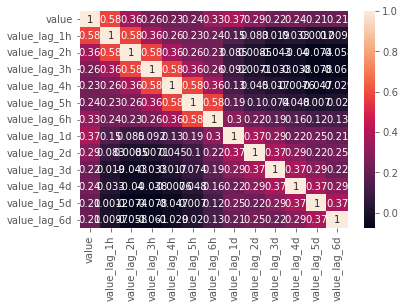

In [20]:
sns.heatmap(data_h.loc[:,:'value_lag_6d'].corr(),annot=True)

In [21]:
n = 10
tss = TimeSeriesSplit(n_splits=n)
# fig, axs = plt.subplots(n, 1, figsize=(15, 8), sharex=True)
# fold = 0
df = data_h
target = 'value'
mape_xgb = []
mape_cat = []
mape_lgbm = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    xgb_model = XGBRegressor()
    xgb_model.fit(train.iloc[:,1:],train[target])
    ypred = xgb_model.predict(test.iloc[:,1:])
    mape = np.absolute(ypred-test[target]).mean()/train[target].mean()
    mape_xgb.append(mape)
    ### CAT ###
    cat_model = CatBoostRegressor(silent=True)
    cat_model.fit(train.iloc[:,1:],train[target])
    ypred = cat_model.predict(test.iloc[:,1:])
    mape = np.absolute(ypred-test[target]).mean()/train[target].mean()
    mape_cat.append(mape)
    ### lgbm ###
    lgbm_model = LGBMRegressor(silent=True)
    lgbm_model.fit(train.iloc[:,1:],train[target])
    ypred = lgbm_model.predict(test.iloc[:,1:])
    mape = np.absolute(ypred-test[target]).mean()/train[target].mean()
    mape_lgbm.append(mape)

print(mape_xgb[-3:], '\n', mape_cat[-3:], '\n', mape_lgbm[-3:],sep='')


[0.41052037559166993, 0.43100745975357035, 0.4096206567710991]
[0.3571957504936195, 0.39613422334739806, 0.38633936255598367]
[0.3402589564170182, 0.3867478286476712, 0.3538061094358334]


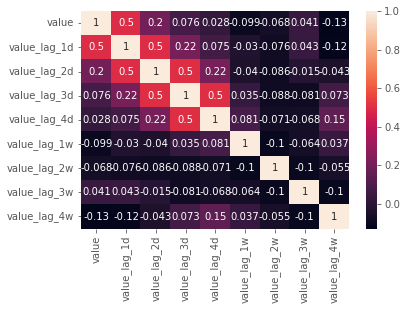

In [22]:
_, data_d = feature_engineering_day(ex44_d,4,4)
sns.heatmap(data_d.loc[:,:'value_lag_4w'].corr(),annot=True)

In [23]:
n = 10
tss = TimeSeriesSplit(n_splits=n)
# fig, axs = plt.subplots(n, 1, figsize=(15, 8), sharex=True)
# fold = 0
df = data_d
target = 'value'
mape_xgb = []
mape_cat = []
mape_lgbm = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    xgb_model = XGBRegressor()
    xgb_model.fit(train.iloc[:,1:],train[target])
    ypred = xgb_model.predict(test.iloc[:,1:])
    mape = np.absolute(ypred-test[target]).mean()/train[target].mean()
    mape_xgb.append(mape)
    ### CAT ###
    cat_model = CatBoostRegressor(silent=True)
    cat_model.fit(train.iloc[:,1:],train[target])
    ypred = cat_model.predict(test.iloc[:,1:])
    mape = np.absolute(ypred-test[target]).mean()/train[target].mean()
    mape_cat.append(mape)
    ### lgbm ###
    lgbm_model = LGBMRegressor(silent=True)
    lgbm_model.fit(train.iloc[:,1:],train[target])
    ypred = lgbm_model.predict(test.iloc[:,1:])
    mape = np.absolute(ypred-test[target]).mean()/train[target].mean()
    mape_lgbm.append(mape)

print(mape_xgb[-3:], '\n', mape_cat[-3:], '\n', mape_lgbm[-3:],sep='')

[0.43300491025689064, 0.340631826402208, 0.36239627424252124]
[0.3903547099103819, 0.3528442080451423, 0.28392120948426197]
[0.34372134878536525, 0.3786606494424729, 0.283170560573285]


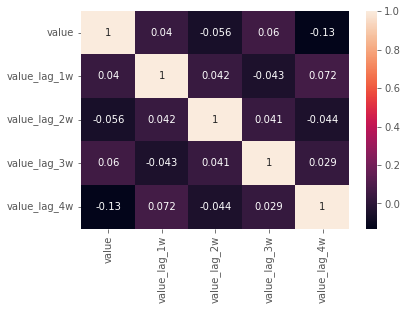

In [24]:
_, data_w = feature_engineering_week(ex44_w,4)
sns.heatmap(data_w.loc[:,:'value_lag_4w'].corr(),annot=True)

[0.4097315443884443, 0.3823916626496542, 0.34119501838876265]
[0.25955065643366293, 0.27302778059380417, 0.19357627401830077]
[0.28599823638664446, 0.233054388911464, 0.1918674480249989]


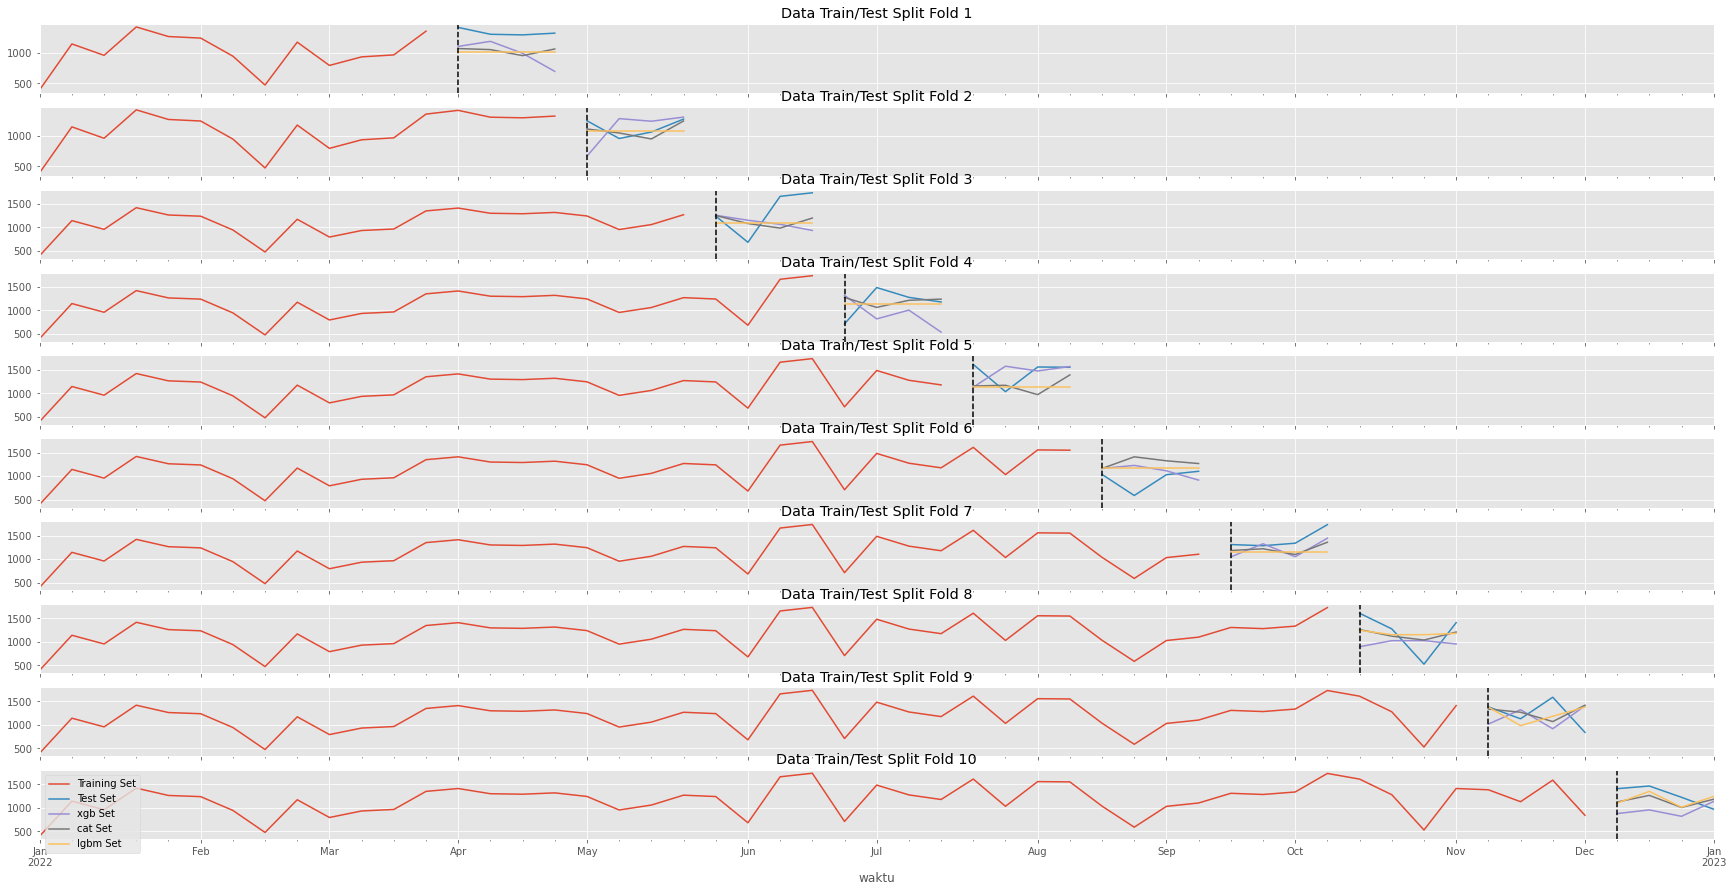

In [25]:
n = 10
tss = TimeSeriesSplit(n_splits=n,test_size=4)
# fig, axs = plt.subplots(n, 1, figsize=(15, 8), sharex=True)
# fold = 0
df = data_w
target = 'value'
fig, axs = plt.subplots(n, 1, figsize=(30, 15), sharex=True)
fold = 0
mape_xgb = []
mape_cat = []
mape_lgbm = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    ### XGB ###
    xgb_model = XGBRegressor()
    xgb_model.fit(train.iloc[:,1:],train[target])
    ypred = xgb_model.predict(test.iloc[:,1:10])
    test['xgb'] = ypred
    mape = np.absolute(ypred-test[target]).mean()/train[target].mean()
    mape_xgb.append(mape)
    
    ### CAT ###
    cat_model = CatBoostRegressor(silent=True)
    cat_model.fit(train.iloc[:,1:],train[target])
    ypred = cat_model.predict(test.iloc[:,1:10])
    test['cat'] = ypred
    mape = np.absolute(ypred-test[target]).mean()/train[target].mean()
    mape_cat.append(mape)

    ### lgbm ###
    lgbm_model = LGBMRegressor(silent=True)
    lgbm_model.fit(train.iloc[:,1:],train[target])
    ypred = lgbm_model.predict(test.iloc[:,1:10])
    test['lgbm'] = ypred
    mape = np.absolute(ypred-test[target]).mean()/train[target].mean()
    mape_lgbm.append(mape)

    ### PLOT ###
    train[target].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold+1}')
    test[target].plot(ax=axs[fold],
                         label='Test Set')
    test['xgb'].plot(ax=axs[fold],
                         label='xgb Set')
    test['cat'].plot(ax=axs[fold],
                         label='cat Set')
    test['lgbm'].plot(ax=axs[fold],
                         label='lgbm Set')

        
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1
plt.legend()
plt.plot()
print(mape_xgb[-3:], '\n', mape_cat[-3:], '\n', mape_lgbm[-3:],sep='')